In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cvxpy as cp
import csv
import imageio
import matplotlib.image as mpimg

In [3]:
from classifier_function import classifier_no_overlap, classifier_overlap

In [4]:
train_cat = np.matrix(np.loadtxt("train_cat.txt", delimiter = ",")) # cat data as matrix
train_grass = np.matrix(np.loadtxt("train_grass.txt", delimiter = ",")) # grass data as matrix

In [5]:
def train_set(train): # train function to get mean, variance from training samples
    K = np.size(train,1) # number of samples/patch for training 
    u = np.mean(train,1)  # mean vector 
    cov = np.cov(train)   # covariance
    return K,u,cov     

In [6]:
# for this the data contains vector of size(64,1) extracted from 8*8 patch. 
# compute mean vector of grass patch vector, covariance of grass patch vector from sample
t_g = train_set(train_grass)
K_grass = t_g[0] # number of training samples(patches) of grass 
u_grass = t_g[1] # mean vector of grass patch vector
cov_grass = t_g[2]  # covariance of grass patch vector

In [7]:
t_c = train_set(train_cat)
K_cat = t_c[0] # number of training samples(patches) of cat
u_cat = t_c[1] # mean vector of cat patch vector
cov_cat = t_c[2]  # covariance of cat patch vector

In [8]:
# compute prior
P_cat = K_cat/(K_grass + K_cat) # prior P_class(cat)
P_grass = 1-P_cat               # prior P_class(grass)   

In [9]:
# reading image to be classified
Y = plt.imread("cat_grass.jpg") / 255

Defining the target class and the parameters for the expression <br>
(x.T).W.x + (w.T).x + w0 = g_class(x)
for 2 classes with unequal covariance
W = -inverse of covariance
w = -W.u where u is mean

In [40]:
# target class t= grass,
# class j = cat
Wj = -1*np.linalg.inv(cov_cat) 
Wt = -1*np.linalg.inv(cov_grass) 
w_j = np.dot(np.linalg.inv(cov_cat),u_cat)
w_t = np.dot(np.linalg.inv(cov_grass), u_grass)

In [42]:
# CW adverserail attack on classifier with no overlap
def CW_attack(Y,lambd, alpha, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass,Wj,Wt,w_j,w_t):
    # preprocess data
    pert_img_curr = Y.copy() #initiate
    pert_img_curr1 = Y.copy() 
    itr_num = 0
    change = 10
    M = np.size(Y,0)
    N = np.size(Y,1)
    cov_inv_cat = np.linalg.inv(cov_cat)
    cov_inv_grass = np.linalg.inv(cov_grass)
    log_Pcat = np.log(P_cat)
    log_Pgrass = np.log(P_grass)
    det_cov_grass = np.log(np.linalg.det(cov_grass))
    det_cov_cat = np.log(np.linalg.det(cov_cat))
    
    ll = 50/lambd
    cat_list = [] # list to store number of cat classifications for each iteration
    change_list = [] # list to store change for each iteration
    
    k_i = 0 # k for iteration to use in dictionary to store intermediate steps
    img_dict = {}
    
    while(itr_num <= 300 and change >= 0.001):
        #pert_img_prev = pert_img_curr
        x_last = (pert_img_curr)*255
        k = 0
        for i in range(M):
            for j in range(N):
                if((i+8>M)or(j+8>N)or(j%8!=0)or(i%8!=0)):
                    continue
                else:
                    patch_vec = np.reshape(pert_img_curr[i:i+8, j:j+8].flatten('F'),(64,1)) #create patch vector

                    x_0 = np.reshape(Y[i:i+8, j:j+8].flatten('F'),(64,1)) # create x_0

                    t_cat = patch_vec - u_cat
                     #-0.5*np.dot(np.dot(t_cat.T,cov_inv_cat),t_cat)
                    G_cat = np.dot(t_cat.T,cov_inv_cat)
                    f_zcat = -0.5*((np.asscalar(np.dot(G_cat,t_cat)))+(det_cov_cat))

                    t_grass = patch_vec - u_grass
                    
                    G_grass = np.dot(t_grass.T,cov_inv_grass)

                    # compute f(z|grass)
                    #f_zgrass = (np.e**(-0.5*np.asscalar(np.dot(G_grass,t_grass))))/(((2*np.pi)**32)*(np.linalg.det(cov_grass)**0.5))

                    f_zgrass = -0.5*((np.asscalar(np.dot(G_grass,t_grass)))+(det_cov_grass))
                    #f_zgrass = -0.5*((np.asscalar(np.dot(G_grass,t_grass)))+(np.log(np.linalg.det(cov_grass))))
                    fcz = f_zcat+ log_Pcat
                    fgz = f_zgrass+log_Pgrass

                    P = fcz-fgz # if P>0 that means classifier says its cat and so we need to perturb                
                    
                    if(P>0):
                        grad = 2*(patch_vec - x_0)+lambd*(np.dot((Wj-Wt),patch_vec) + w_j - w_t)
                        pert_patch= patch_vec - alpha*grad
                        pert_patch = np.clip(pert_patch,0.0,1.0)
                        z_pert = np.reshape(pert_patch, (8, 8), order ='F')
                        pert_img_curr[i:i+8, j:j+8]= z_pert
                        k+=1
    
        if((itr_num%ll == 0)):
            img_dict[k_i] = pert_img_curr.copy() 
            k_i+=1
            
        cat_list.append(k)
        x_curr = (pert_img_curr)*255
        #change = np.linalg.norm((pert_img_curr - pert_img_prev)*255)
        change = np.linalg.norm(x_curr - x_last)
        itr_num += 1
        change_list.append(change)
        #print(itr_num)
    #perturbation_added = Y-pert_img_curr
    #frobenius_norm = change
    return pert_img_curr, cat_list,change_list, img_dict       

In [43]:
# function to plot results of attack on classifierr with no overlap
def fun2(result): # i and iv
    Output = classifier_no_overlap(result[0], P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass)
    Output_no_ovelap = Output[0]
    print("the number of patches classified as cat = ",Output[1])

    fig = plt.figure(figsize=(18, 38))
    plt.subplot(1, 3, 3)
    plt.title('Classifier with no overlap')
    plt.imshow(Output_no_ovelap*255, cmap = "gray")
    plt.subplot(1, 3, 2)
    plt.title('Final Perturbed image')
    plt.imshow(result[0], cmap = 'gray') 
    plt.subplot(1, 3, 1)
    plt.title('Original image')
    plt.imshow(Y, cmap = "gray")
    return fig

In [44]:
# function to plot results of attack on classifierr with overlap
def fun2_o(result): # i and iv
    Output = classifier_overlap(result[0], P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass)
    Output_ovelap = Output[0]
    print("the number of patches classified as cat = ",Output[1])

    fig = plt.figure(figsize=(18, 38))
    plt.subplot(1, 3, 3)
    plt.title('Classifier with overlap')
    plt.imshow(Output_ovelap*255, cmap = "gray")
    plt.subplot(1, 3, 2)
    plt.title('Final Perturbed image')
    plt.imshow(result[0], cmap = 'gray') 
    plt.subplot(1, 3, 1)
    plt.title('Original image')
    plt.imshow(Y, cmap = "gray")
    return fig

In [23]:
# extra plots to analyze
def extra_plot(result):
    fig = plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel('iterations')
    plt.ylabel('number of cat pixels')
    plt.title('number of cat pixels vs iteration')

    plt.plot([i for i in range(1,len(result[1])+1)],result[1])
    plt.subplot(1, 2, 2)
    plt.xlabel('iterations')
    plt.ylabel('Change')
    plt.title('Change vs iteration')

    plt.plot([i for i in range(1,len(result[2])+1)],result[2])
    return fig

In [24]:
# function to plot intermediate steps
def inter(res):
    img_matrix = res[3]
    fig_dict = {}
    fig = plt.figure(figsize=(18, 38))
    for i in range(len(img_matrix)):
        fig_dict[i] = classifier_no_overlap(img_matrix[i], P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass)[0]    
        fig.add_subplot(1,len(img_matrix)+1,i+1)
        plt.imshow(fig_dict[i]*255, cmap = "gray")
        plt.title('intermediate steps = ' + str(i+1) )
    return fig

In [45]:
# function to plot intermediate steps for attack on classifer wiht overlap
def inter_o(res):
    img_matrix = res[3]
    fig_dict = {}
    fig = plt.figure(figsize=(18, 38))
    for i in range(len(img_matrix)):
        fig_dict[i] = classifier_overlap(img_matrix[i], P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass)[0]    
        fig.add_subplot(1,len(img_matrix)+1,i+1)
        plt.imshow(fig_dict[i]*255, cmap = "gray")
        plt.title('intermediate steps = ' + str(i+1) )
    return fig

In [46]:
#function to find and show perturbation
def pert(Y,result): #ii and iii
    
    fig = plt.figure(figsize=(7.5, 15))
    perturbation = np.abs(Y - result[0])
    plt.title('Perturbation')
    plt.imshow(perturbation, cmap = 'gray') 
    f_norm = np.linalg.norm(perturbation)
    print("Frobenius norm of the perturbation = ", f_norm)
    
    return fig

In [47]:
# attack on the classsifier with no overlap
Y = plt.imread("cat_grass.jpg") / 255
lambd = 5
alpha = 0.0001
result = CW_attack(Y,lambd, alpha, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass,Wj,Wt,w_j,w_t)
pert_img = result[0]

the number of patches classified as cat =  0


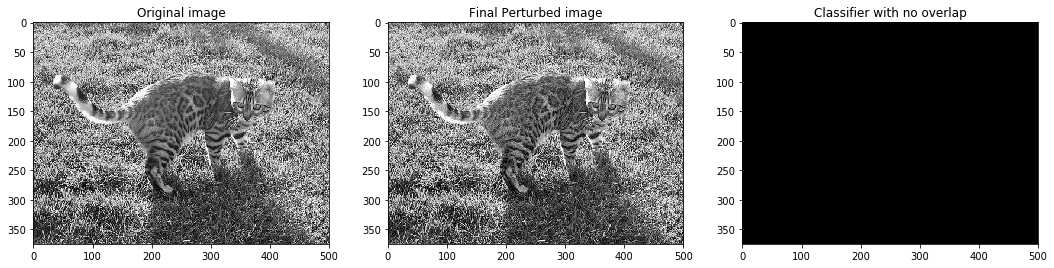

In [48]:
fig1 =  fun2(result)

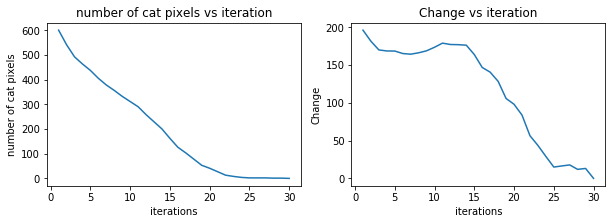

In [49]:
fig2 = extra_plot(result)

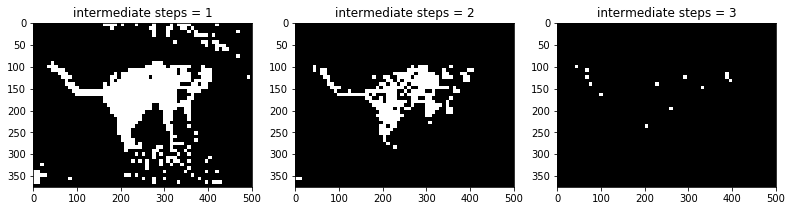

In [50]:
fig3 = inter(result)

Frobenius norm of the perturbation =  8.928742803780711


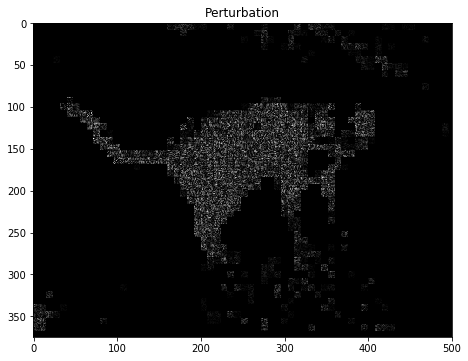

In [51]:
fig3 = pert(Y,result)

## lambda = 10

In [32]:
Y = plt.imread("cat_grass.jpg") / 255
lambd = 10
alpha = 0.0001
result2 = CW_attack(Y,lambd, alpha, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass,Wj,Wt,w_j,w_t)

the number of patches classified as cat =  0


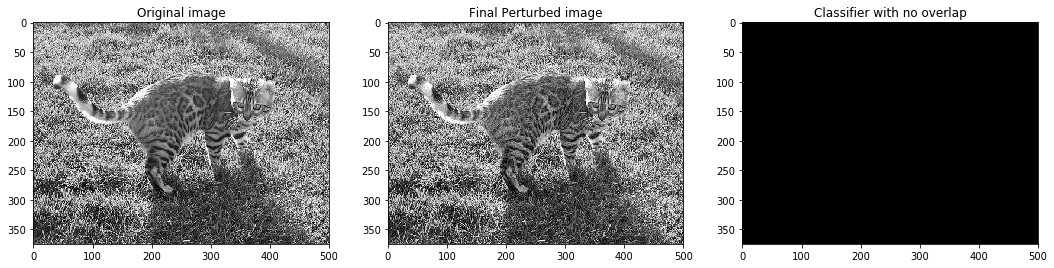

In [33]:
fig1 =  fun2(result2)

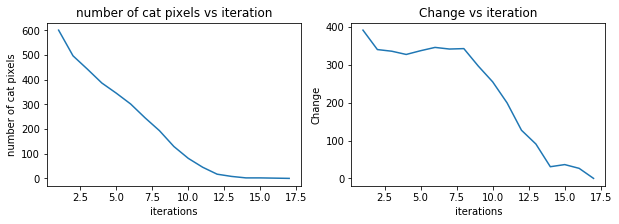

In [34]:
fig2 = extra_plot(result2)

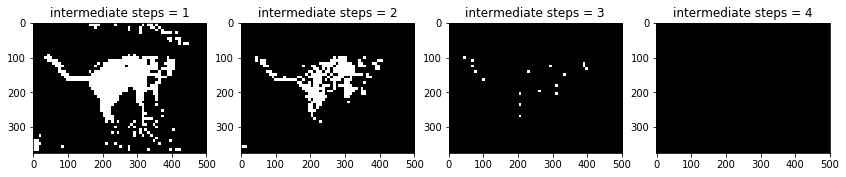

In [35]:
fig3 = inter(result2)

Frobenius norm of the perturbation =  9.69793877092967


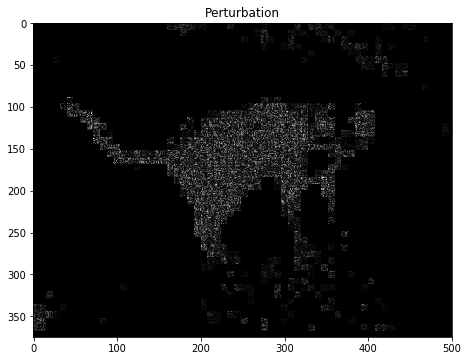

In [36]:
fig4 = pert(Y,result2)

## lambda = 1

In [52]:
Y = plt.imread("cat_grass.jpg") / 255
lambd = 1
alpha = 0.0001
result3 = CW_attack(Y,lambd, alpha, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass,Wj,Wt,w_j,w_t)

the number of patches classified as cat =  0


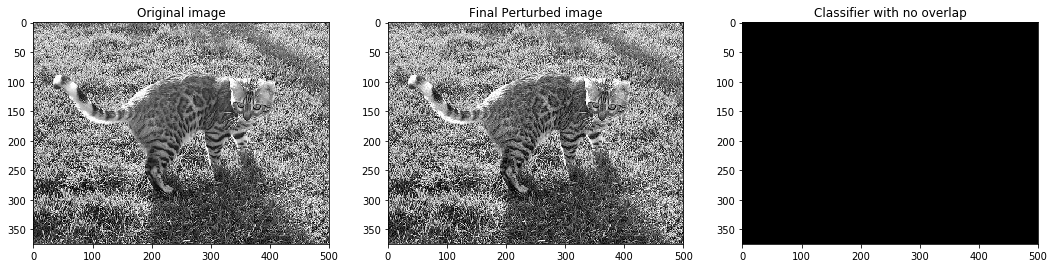

In [53]:
fig1 =  fun2(result3)

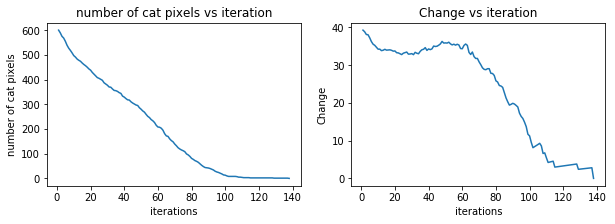

In [54]:
fig2 = extra_plot(result3)

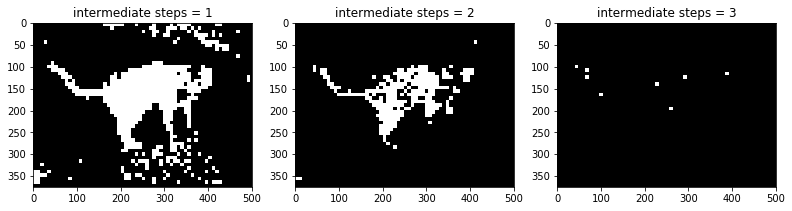

In [55]:
fig3 = inter(result3)

Frobenius norm of the perturbation =  8.253352243144638


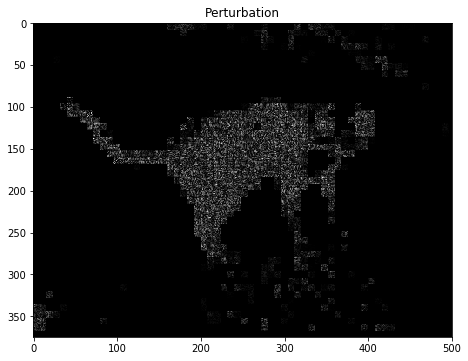

In [56]:
fig4 = pert(Y,result3)

Comments

Text(0.5, 1.0, 'effect of increasing lambda')

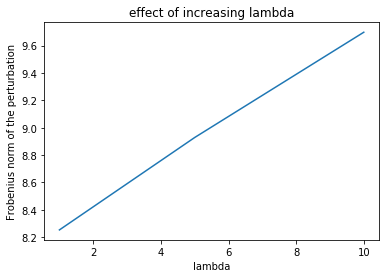

In [57]:
A = [8.253352243144638,8.928742803780711 ,9.69793877092967]
B = [1,5,10]
plt.plot(B,A)

plt.ylabel('Frobenius norm of the perturbation')
plt.xlabel('lambda')
plt.title('effect of increasing lambda')

For each lambda,<br> Fig = final output and classification.<br> fig 2 = shows the convergence(how change and number of cat pixels go down as the attack progresses). <br> fig 3 = shows classification of intermediate steps.<br>  fig 4 = shows where perturbation is done.<br>
comments: 
- from the above plots we see that in this case of classifier with overlap, the CW attack perfectly fools the classifier for all cases as a complete black image is given as output. The final perturbed image is very similar to the original and so the attack is a success. 
- As the lambda is increased we incresease the weight of the second term of the gradient, so the attack becomes stronger. This is shown in the last plot where final perturbation increases with increase in the value of lambda.On increasing lambda, the attack converges faster and takes lesser iterations.

- As the alpha is increased, the step size increases and there is chance that it skips the minima and keeps on changng. This problem was encountered on using high value of lambda and the change kept on jumping instead of converging. Using small lambda ensures that minima is reached but it may take more number of iterations.


# CW adverserial attack on classifier with overlap

In [58]:
# CW adverserial attack on classi
def classifier_overlap(Y, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass):
    
    M = np.size(Y,0)
    N = np.size(Y,1)
    Output = np.zeros((M-8,N-8)) # to store each patch for output graph
    
    cat_c = 0
    
    cov_inv_cat = np.linalg.inv(cov_cat)
    cov_inv_grass = np.linalg.inv(cov_grass)
    log_Pcat = np.log(P_cat)
    log_Pgrass = np.log(P_grass)
    det_cov_grass = np.log(np.linalg.det(cov_grass))
    det_cov_cat = np.log(np.linalg.det(cov_cat))
    
    for i in range(M-8):
        for j in range(N-8):
            z_patch = Y[i:i+8, j:j+8]
            z1 = z_patch.flatten('F') # flatten patch from 8,8 to a column (64,) 
            z = np.reshape(z1,(64,1))  # now to (64,1) 
            
            t_cat = z - u_cat            
            G_cat = np.dot(t_cat.T,cov_inv_cat)
            f_zcat = -0.5*((np.asscalar(np.dot(G_cat,t_cat)))+(det_cov_cat))

            t_grass = z - u_grass            
            G_grass = np.dot(t_grass.T,cov_inv_grass)
            # compute f(z|grass)
            f_zgrass = -0.5*((np.asscalar(np.dot(G_grass,t_grass)))+(det_cov_grass))
        
            
            fcz = f_zcat+ log_Pcat
            fgz = f_zgrass+ log_Pgrass
            
            if fcz > fgz: 
                Output[i,j] = 1
                cat_c = cat_c + 1
    return Output, cat_c


In [59]:
def CW_attack_o(Y,lambd, alpha, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass,Wj,Wt,w_j,w_t,ll):
    # preprocess data
    pert_img_curr = Y.copy() #initiate
    
    itr_num = 0
    
    change = 10
    d = 64
    M = np.size(Y,0)
    N = np.size(Y,1)
    #X_0 = np.reshape(Y.flatten('F'),(M*N,1))
    
    #constants
    cov_inv_cat = np.linalg.inv(cov_cat)
    cov_inv_grass = np.linalg.inv(cov_grass)
    det_cov_grass = np.log(np.linalg.det(cov_grass))
    det_cov_cat = np.log(np.linalg.det(cov_cat))  
    log_P_cat = np.log(P_cat)
    log_P_grass = np.log(P_grass)
    
    cat_list = []
    #arraylist_of_pert_img = 
    change_list = []
    
    k_i = 0 # k for iteration to use in dictionary
    img_dict = {}
           
    while(itr_num <= 300 and change >= 0.01):
        k=0
        pert_img_prev = pert_img_curr 
        #x_last = (pert_img_curr)*255
        gr =np.zeros((M,N))
        for i in range(M-8):
            for j in range(N-8):
                
                patch_vec = np.reshape(pert_img_curr[i:i+8, j:j+8].flatten('F'),(64,1)) #create patch vector
                
                t_cat = patch_vec - u_cat
                G_cat = np.dot(t_cat.T,cov_inv_cat)
                f_zcat = -0.5*((np.asscalar(np.dot(G_cat,t_cat)))+(det_cov_cat))                
                
                t_grass = patch_vec - u_grass
                G_grass = np.dot(t_grass.T,cov_inv_grass)
                f_zgrass = -0.5*((np.asscalar(np.dot(G_grass,t_grass)))+(det_cov_grass))
                #f_zgrass = -0.5*((np.asscalar(np.dot(G_grass,t_grass)))+(np.log(np.linalg.det(cov_grass))))
                fcz = f_zcat+log_P_cat
                fgz = f_zgrass+log_P_grass                
                P = fcz-fgz # if P>0 that means classifier says its cat and so we need to perturb     
                if(P>0): 
                    gr_patch = (np.dot((Wj-Wt),patch_vec) + w_j - w_t)
                    gr_patch = np.reshape(gr_patch, (8, 8), order ='F')
                    gr[i:i+8, j:j+8] = gr[i:i+8, j:j+8] + gr_patch 
                    k=k+1
        
        if((itr_num%ll == 0)):
            img_dict[k_i] = pert_img_curr.copy() 
            k_i+=1            
        #print(np.linalg.norm(gr))
        #print("cat =", k)
        cat_list.append(k)
        if(k ==0):
            grad = 0
        else:
            grad = 2*(pert_img_curr - Y) + lambd*gr
        
        
        
        
        pert_img_curr = np.clip(pert_img_curr - alpha*grad,0.0,1.0)
        #x_curr = (pert_img_curr)*255
        #change = np.linalg.norm(x_curr - x_last)
        change = np.linalg.norm(pert_img_curr - pert_img_prev)
        #print(change)
        change_list.append(change)
        itr_num += 1
        #print(itr_num)
        
    return pert_img_curr, cat_list, change_list, img_dict       

## lambda = 0.5


In [60]:
Y = plt.imread("cat_grass.jpg") / 255
lambd = 0.5
alpha = 0.0001
ll = 8 
result_o1 = CW_attack_o(Y,lambd, alpha, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass,Wj,Wt,w_j,w_t,ll)

the number of patches classified as cat =  3


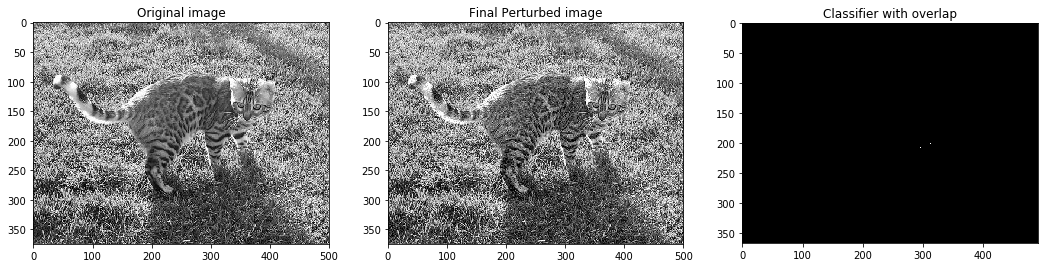

In [61]:
fig1 =  fun2_o(result_o1)

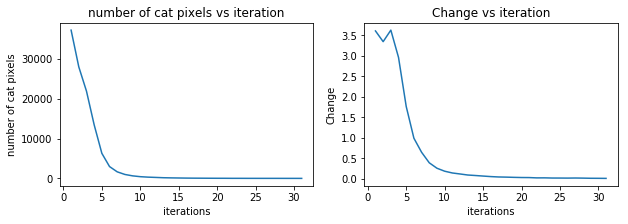

In [62]:
fig2 = extra_plot(result_o1)

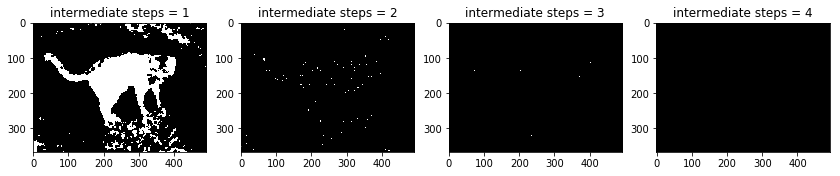

In [63]:
fig3 = inter_o(result_o1)

Frobenius norm of the perturbation =  14.05926068769758


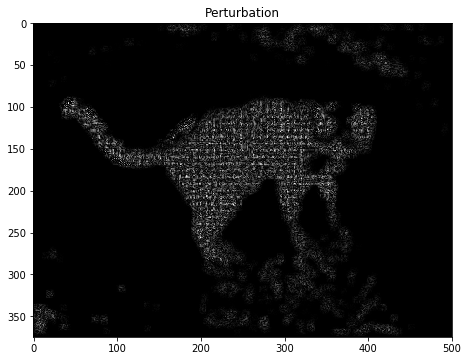

In [65]:
fig4 = pert(Y,result_o1)

## lambda = 1


In [66]:
Y = plt.imread("cat_grass.jpg") / 255
lambd = 1
alpha = 0.0001
ll = 8 
result_o2 = CW_attack_o(Y,lambd, alpha, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass,Wj,Wt,w_j,w_t,ll)

the number of patches classified as cat =  3


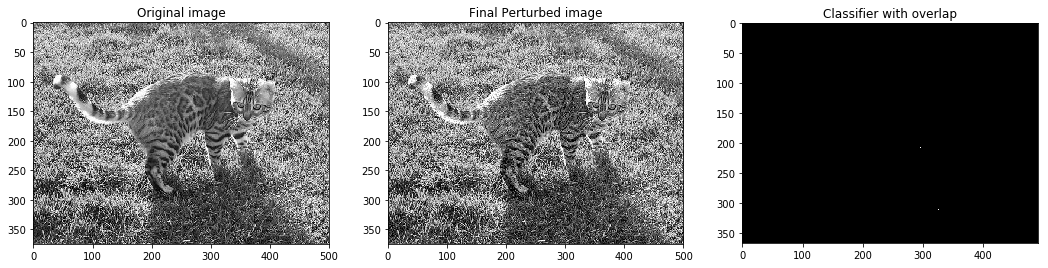

In [67]:
fig1 =  fun2_o(result_o2)

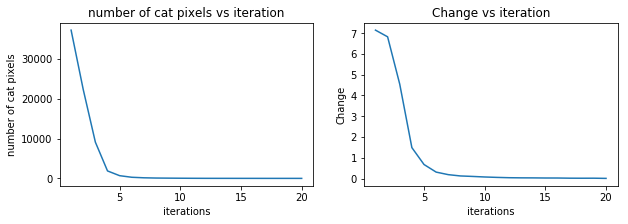

In [68]:
fig2 = extra_plot(result_o2)

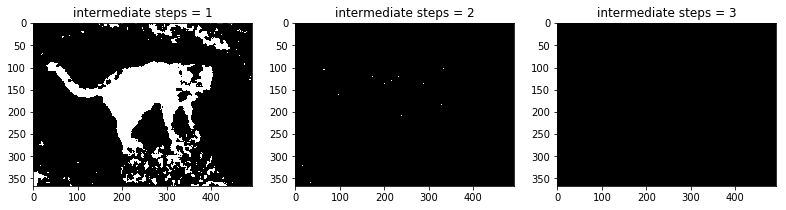

In [69]:
fig3 = inter_o(result_o2)

Frobenius norm of the perturbation =  16.15856320874715


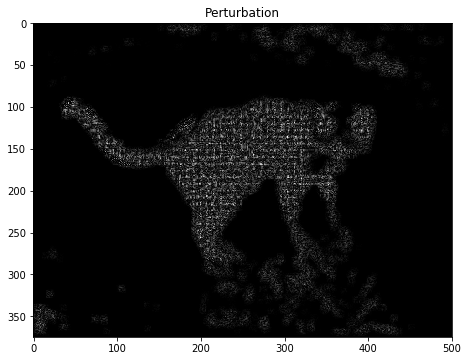

In [70]:
fig4 = pert(Y,result_o2)

## lambda = 5


In [71]:
Y = plt.imread("cat_grass.jpg") / 255
lambd = 5
alpha = 0.0001
ll = 2
result_o3 = CW_attack_o(Y,lambd, alpha, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass,Wj,Wt,w_j,w_t,ll)

the number of patches classified as cat =  0


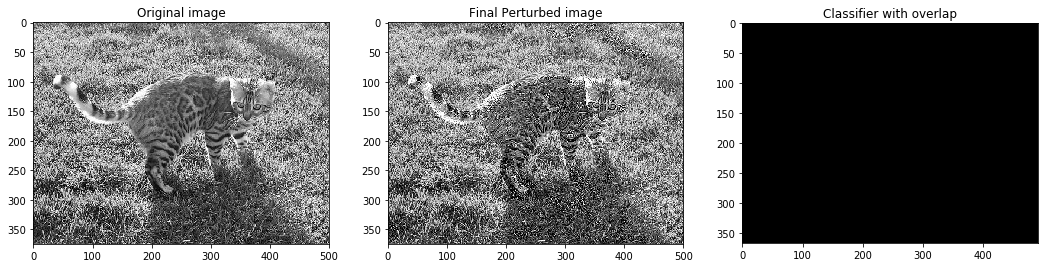

In [72]:
fig1 =  fun2_o(result_o3)

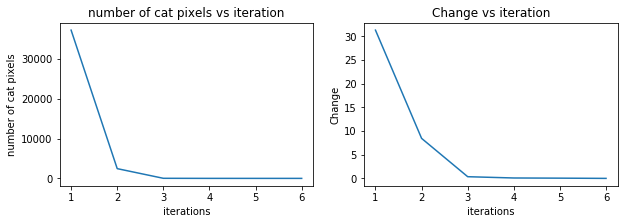

In [73]:
fig2 = extra_plot(result_o3)

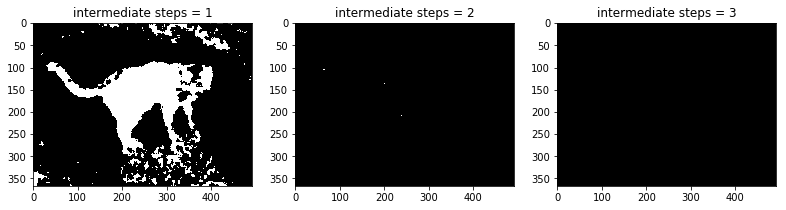

In [74]:
fig3 = inter_o(result_o3)

Frobenius norm of the perturbation =  33.623838116465706


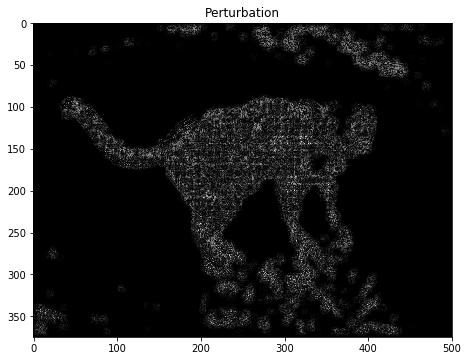

In [75]:
fig4 = pert(Y,result_o3)

Text(0.5, 1.0, 'effect of increasing lambda')

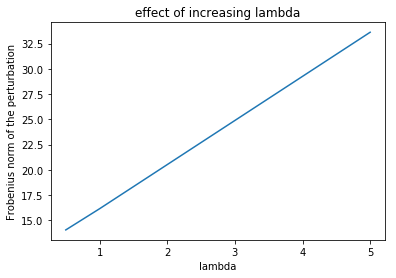

In [76]:
A = [14.05926068769758,16.15856320874715 ,33.623838116465706]
B = [0.5,1,5]
plt.plot(B,A)

plt.ylabel('Frobenius norm of the perturbation')
plt.xlabel('lambda')
plt.title('effect of increasing lambda')

For each lambda,<br> Fig = final output and classification.<br> fig 2 = shows the convergence(how change and number of cat pixels go down as the attack progresses). <br> fig 3 = shows classification of intermediate steps.<br>  fig 4 = shows where perturbation is done.<br>
comments: 
- from the above plots we see that in this case of classifier with overlap, the CW attack fools the classifier, though for lambda = 1 & 0.5 its not perfect as 3 pixels are still calssified as cat. But this can be removed by making change criteria more stringent. For all cases almost complete black image is given as output. The final perturbed image is very similar to the original and so the attack is a success. 
- As the lambda is increased we incresease the weight of the second term of the gradient, so the attack becomes stronger. This is shown in the last plot where final perturbation increases with increase in the value of lambda. On increasing lambda, the attack converges faster and takes lesser iterations.

- As the alpha is increased, the step size increases and there is chance that it skips the minima and keeps on changing. This problem was encountered on using high value of lambda and the change kept on jumping instead of converging. Using small lambda ensures that minima is reached but it may take more number of iterations.

- In terms of comparing the quality of attack for overlapping and non overlapping, my results show that cw attack for classifier without overlap is better for the following reasons:
> - the Frobenius norm of the perturbation is lesser for CW attack on classifier without overlap. So that means overlap CW attack has to add more perturbation to fool the classifier.   
 - It is faster as it has to go thorugh lesser number of cells.
 - For 1 case the CW attack with overlap does not give full black image as it converges due to change criterio but still has cat pixels classified.

